In [1]:

#%% Import modules
import os
import numpy as np   
import matplotlib.pyplot as mpyplot
import matplotlib.dates as mdates 
import matplotlib.colors as mcolors 
import matplotlib.style as mstyle
import pandas as pandas
import cmocean
import datetime
import scipy as scipy
from scipy import stats,signal
import pandas
import xarray as xr              


print("done importing modules")


done importing modules


In [2]:
#%% Define file locations
WRF_DIRECTORY_26 = "/pl/active/JKL_IDEAL/hurricanes/sst_26/"  
WRF_DIRECTORY_28 = "/pl/active/JKL_IDEAL/hurricanes/sst_28/"  
WRF_DIRECTORY_30 = "/pl/active/JKL_IDEAL/hurricanes/sst_30/"  
WRF_DIRECTORY_32 = "/pl/active/JKL_IDEAL/hurricanes/sst_32/"   #"/pl/active/WRFLES_GAD/hurricanes/sst_32_earliderd04/"  
WRF_DIRECTORY_34 = "/pl/active/JKL_IDEAL/hurricanes/sst_34/"  


fileName_3 = '3-sec_profiles.txt'
fileName_10 = '10-min_profiles.txt'

dirFig = "/pl/active/JKL_IDEAL/hurricanes/Figures/"



In [3]:
#%% Turbine specs
z_hh = 90
D = 126

In [4]:
#%% Extract wind speed propfiles at different radial locations for 3-sec winds
file_26 = np.loadtxt(WRF_DIRECTORY_26+fileName_3,delimiter=',',skiprows=1)
z_26 = file_26[:,0]
U3_z_26 = file_26[:,1:]
file_26 = np.loadtxt(WRF_DIRECTORY_26+fileName_3,delimiter=',',max_rows=1)
r_26 = file_26[:]

file_28 = np.loadtxt(WRF_DIRECTORY_28+fileName_3,delimiter=',',skiprows=1)
z_28 = file_28[:,0]
U3_z_28 = file_28[:,1:]
file_28 = np.loadtxt(WRF_DIRECTORY_28+fileName_3,delimiter=',',max_rows=1)
r_28 = file_28[:]

file_30 = np.loadtxt(WRF_DIRECTORY_30+fileName_3,delimiter=',',skiprows=1)
z_30 = file_30[:,0]
U3_z_30 = file_30[:,1:]
file_30 = np.loadtxt(WRF_DIRECTORY_30+fileName_3,delimiter=',',max_rows=1)
r_30 = file_30[:]

file_32 = np.loadtxt(WRF_DIRECTORY_32+fileName_3,delimiter=',',skiprows=1)
z_32 = file_32[:,0]
U3_z_32 = file_32[:,1:]
file_32 = np.loadtxt(WRF_DIRECTORY_32+fileName_3,delimiter=',',max_rows=1)
r_32 = file_32[:]

file_34 = np.loadtxt(WRF_DIRECTORY_34+fileName_3,delimiter=',',skiprows=1)
z_34 = file_34[:,0]
U3_z_34 = file_34[:,1:]
file_34 = np.loadtxt(WRF_DIRECTORY_34+fileName_3,delimiter=',',max_rows=1)
r_34 = file_34[:]


In [5]:
#%% Extract wind speed propfiles at different radial locations for 10-min winds
file_26 = np.loadtxt(WRF_DIRECTORY_26+fileName_10,delimiter=',',skiprows=1)
U10_z_26 = file_26[:,1:]

file_28 = np.loadtxt(WRF_DIRECTORY_28+fileName_10,delimiter=',',skiprows=1)
U10_z_28 = file_28[:,1:]

file_30 = np.loadtxt(WRF_DIRECTORY_30+fileName_10,delimiter=',',skiprows=1)
U10_z_30 = file_30[:,1:]

file_32 = np.loadtxt(WRF_DIRECTORY_32+fileName_10,delimiter=',',skiprows=1)
U10_z_32 = file_32[:,1:]

file_34 = np.loadtxt(WRF_DIRECTORY_34+fileName_10,delimiter=',',skiprows=1)
U10_z_34 = file_34[:,1:]


In [6]:
#%% Colors for each case
col_26 = 'steelblue'
col_28 = 'tab:green'
col_30 = 'goldenrod'
col_32 = 'firebrick'
col_34 = 'tab:purple'
cols = [col_26,col_28,col_30,col_32,col_34]


In [7]:
#%% Eyewall for each case
r_eye_26 = 13805
r_eye_28 = 21300
r_eye_30 = 20333
r_eye_32 = 27055
r_eye_34 = 33638.915

In [8]:
#%% Find radial locations of interest
r_r = np.arange(0.8,1.3,0.1)

i_r_26 = np.zeros(len(r_r))
i_r_28 = np.zeros(len(r_r))
i_r_30 = np.zeros(len(r_r))
i_r_32 = np.zeros(len(r_r))
i_r_34 = np.zeros(len(r_r))

for i in np.arange(len(r_r)):
    i_r_26[i] = np.argmin(np.abs(r_26/r_eye_26 - r_r[i]))
    i_r_28[i] = np.argmin(np.abs(r_28/r_eye_28 - r_r[i]))
    i_r_30[i] = np.argmin(np.abs(r_30/r_eye_30 - r_r[i]))
    i_r_32[i] = np.argmin(np.abs(r_32/r_eye_32 - r_r[i]))
    i_r_34[i] = np.argmin(np.abs(r_34/r_eye_34 - r_r[i]))

i_r_26 = i_r_26.astype('int')
i_r_28 = i_r_28.astype('int')
i_r_30 = i_r_30.astype('int')
i_r_32 = i_r_32.astype('int')
i_r_34 = i_r_34.astype('int')

## Current IEC profiles for 3-sec and 10-min winds

In [9]:
#%% Define functions to estiamte atmospheric conditions during extreme events (IEC models)

def EWM_turbulent(u_ref,u_hub,z_rotor,z_hub):
    # 10-min hub-height wind speed for 50-year and 1-year recurrence
    u_50 = u_ref*((z_rotor/z_hub)**0.11);
    u_1 = 0.8*u_50;
    # Turbulence standard deviation
    std = 0.11*u_hub
    return [u_50,u_1,std]

def EWM_steady(u_ref,z_rotor,z_hub):
    # 3-sec hub-height wind speed for 50-year and 1-year recurrence
    u_e50 = 1.4*u_ref*((z_rotor/z_hub)**0.11);
    u_e1 = 0.8*u_e50;
    return [u_e50,u_e1]

# Reference conditions for turbine class
I_ref = 0.16 # Class A turbine
U_ref = np.array([50]) # Class I turbine
U_ref_T = np.array([57]) # Class I turbine


z_TL = np.linspace(10,250,20)
i_z_IEC = np.argmin(np.abs(z_TL - z_hh))

## Class I turbine
# EWM turbulent wind model
# U_hub = 0.95*U_ref
U_hub = 0.95*U_ref
U_50_classI,U_1_classI,STD_classI = EWM_turbulent(U_ref,U_hub,z_TL,z_hh)
print('10-min extreme wind speed is %f (%f) for 50-year and 1-year recurrence' % (U_50_classI[i_z_IEC],U_1_classI[i_z_IEC]))
print('Turbulence standard deviation is %f' % (STD_classI))

# EWM steady wind model
# U_hub = U_e50
U_e50_classI,U_e1_classI = EWM_steady(U_ref,z_TL,z_hh)
print('3-sec extreme wind speed is %f (%f) for 50-year and 1-year recurrence' % (U_e50_classI[i_z_IEC],U_e1_classI[i_z_IEC]))


## Class T turbine
# EWM turbulent wind model
# U_hub = 0.95*U_ref
U_hub = 0.95*U_ref_T
U_50_classT,U_1_classT,STD_classT = EWM_turbulent(U_ref_T,U_hub,z_TL,z_hh)
print('10-min extreme wind speed is %f (%f) for 50-year and 1-year recurrence' % (U_50_classT[i_z_IEC],U_1_classT[i_z_IEC]))
print('Turbulence standard deviation is %f' % (STD_classT))

# EWM steady wind model
# U_hub = U_e50
U_e50_classT,U_e1_classT = EWM_steady(U_ref_T,z_TL,z_hh)
print('3-sec extreme wind speed is %f (%f) for 50-year and 1-year recurrence' % (U_e50_classT[i_z_IEC],U_e1_classT[i_z_IEC]))



10-min extreme wind speed is 49.737170 (39.789736) for 50-year and 1-year recurrence
Turbulence standard deviation is 5.225000
3-sec extreme wind speed is 69.632038 (55.705630) for 50-year and 1-year recurrence
10-min extreme wind speed is 56.700374 (45.360299) for 50-year and 1-year recurrence
Turbulence standard deviation is 5.956500
3-sec extreme wind speed is 79.380523 (63.504418) for 50-year and 1-year recurrence


## Compare IEC and hurricane data

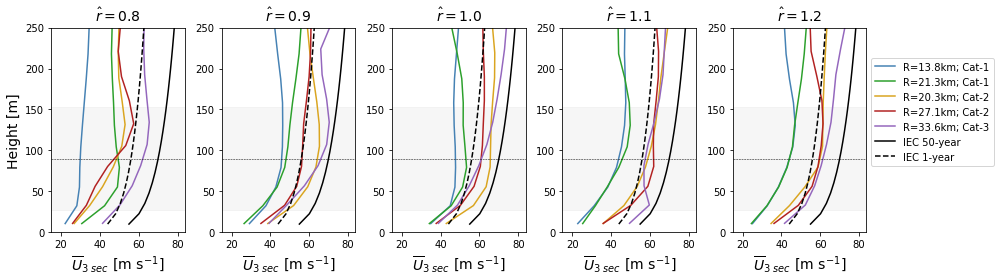

In [10]:
#%% Figure showing 3-sec wind speed profile at different radial locations
minnn = 0
maxxx = 100

mpyplot.figure(figsize=(14,4))
for i in np.arange(len(r_r)):
    mpyplot.subplot(1,len(r_r),i+1)
    mpyplot.title(r'$\hat{r} = $'+str(r_r[i]),fontsize=14)
    # Hurricane data
    if i==len(r_r)-1:
        mpyplot.plot(U3_z_26[:,i_r_26[i]],z_26,color=col_26,label='R='+str(np.round(r_eye_26/1000,1))+'km; Cat-1')
        mpyplot.plot(U3_z_28[:,i_r_28[i]],z_28,color=col_28,label='R='+str(np.round(r_eye_28/1000,1))+'km; Cat-1')
        mpyplot.plot(U3_z_30[:,i_r_30[i]],z_30,color=col_30,label='R='+str(np.round(r_eye_30/1000,1))+'km; Cat-2')
        mpyplot.plot(U3_z_32[:,i_r_32[i]],z_32,color=col_32,label='R='+str(np.round(r_eye_32/1000,1))+'km; Cat-2')
        mpyplot.plot(U3_z_34[:,i_r_34[i]],z_34,color=col_34,label='R='+str(np.round(r_eye_34/1000,1))+'km; Cat-3')
        mpyplot.plot(U_e50_classI,z_TL,'-k',label='IEC 50-year')
        mpyplot.plot(U_e1_classI,z_TL,'--k',label='IEC 1-year')
        mpyplot.legend(loc=3,ncol=1,bbox_to_anchor=[1, 0.3])
    else:
        mpyplot.plot(U3_z_26[:,i_r_26[i]],z_26,color=col_26)
        mpyplot.plot(U3_z_28[:,i_r_28[i]],z_28,color=col_28)
        mpyplot.plot(U3_z_30[:,i_r_30[i]],z_30,color=col_30)
        mpyplot.plot(U3_z_32[:,i_r_32[i]],z_32,color=col_32)
        mpyplot.plot(U3_z_34[:,i_r_34[i]],z_34,color=col_34)
        mpyplot.plot(U_e50_classI,z_TL,'-k')
        mpyplot.plot(U_e1_classI,z_TL,'--k')
    # Turbine rotor layer
    mpyplot.fill([minnn,maxxx,maxxx,minnn],[z_hh-0.5*D,z_hh-0.5*D,z_hh+0.5*D,z_hh+0.5*D],alpha=0.2,color='lightgrey')
    mpyplot.plot([minnn,maxxx],[z_hh,z_hh],'--k',linewidth=0.5)
    # Limits
    mpyplot.ylim(0,250)
    mpyplot.xlim(0.90*np.min(U3_z_26),1.05*np.max(U3_z_34))
    # Labels
    if i==0:
        mpyplot.ylabel('Height [m]',fontsize=14)
    mpyplot.xlabel(r'$\overline{U}_{3\ sec}$ [m s$^{-1}$]',fontsize=14)
    
mpyplot.tight_layout()

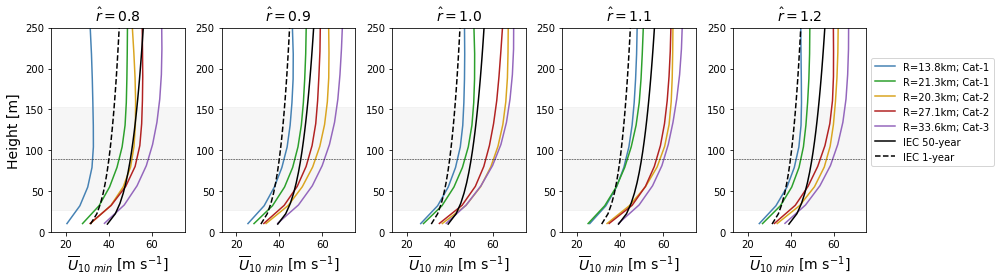

In [11]:
#%% Figure showing 10-min wind speed profile at different radial locations
minnn = 0
maxxx = 100
z_hh = 90
D = 126

mpyplot.figure(figsize=(14,4))
for i in np.arange(len(r_r)):
    mpyplot.subplot(1,len(r_r),i+1)
    mpyplot.title(r'$\hat{r} = $'+str(r_r[i]),fontsize=14)
    # Hurricane data
    if i==len(r_r)-1:
        mpyplot.plot(U10_z_26[:,i_r_26[i]],z_26,color=col_26,label='R='+str(np.round(r_eye_26/1000,1))+'km; Cat-1')
        mpyplot.plot(U10_z_28[:,i_r_28[i]],z_28,color=col_28,label='R='+str(np.round(r_eye_28/1000,1))+'km; Cat-1')
        mpyplot.plot(U10_z_30[:,i_r_30[i]],z_30,color=col_30,label='R='+str(np.round(r_eye_30/1000,1))+'km; Cat-2')
        mpyplot.plot(U10_z_32[:,i_r_32[i]],z_32,color=col_32,label='R='+str(np.round(r_eye_32/1000,1))+'km; Cat-2')
        mpyplot.plot(U10_z_34[:,i_r_34[i]],z_34,color=col_34,label='R='+str(np.round(r_eye_34/1000,1))+'km; Cat-3')
        mpyplot.plot(U_50_classI,z_TL,'-k',label='IEC 50-year')
        mpyplot.plot(U_1_classI,z_TL,'--k',label='IEC 1-year')
        mpyplot.legend(loc=3,ncol=1,bbox_to_anchor=[1, 0.3])
    else:
        mpyplot.plot(U10_z_26[:,i_r_26[i]],z_26,color=col_26)
        mpyplot.plot(U10_z_28[:,i_r_28[i]],z_28,color=col_28)
        mpyplot.plot(U10_z_30[:,i_r_30[i]],z_30,color=col_30)
        mpyplot.plot(U10_z_32[:,i_r_32[i]],z_32,color=col_32)
        mpyplot.plot(U10_z_34[:,i_r_34[i]],z_34,color=col_34)
        mpyplot.plot(U_50_classI,z_TL,'-k')
        mpyplot.plot(U_1_classI,z_TL,'--k')
    # Turbine rotor layer
    mpyplot.fill([minnn,maxxx,maxxx,minnn],[z_hh-0.5*D,z_hh-0.5*D,z_hh+0.5*D,z_hh+0.5*D],alpha=0.2,color='lightgrey')
    mpyplot.plot([minnn,maxxx],[z_hh,z_hh],'--k',linewidth=0.5)
    # Limits
    mpyplot.ylim(0,250)
    mpyplot.xlim(0.90*np.min(U10_z_26),1.05*np.max(U10_z_34))
    # Labels
    if i==0:
        mpyplot.ylabel('Height [m]',fontsize=14)
    mpyplot.xlabel(r'$\overline{U}_{10\ min}$ [m s$^{-1}$]',fontsize=14)
    
mpyplot.tight_layout()

In [12]:
print('These wind profiles represent profiles seen for typical (median) hub-height conditions')

These wind profiles represent profiles seen for typical (median) hub-height conditions


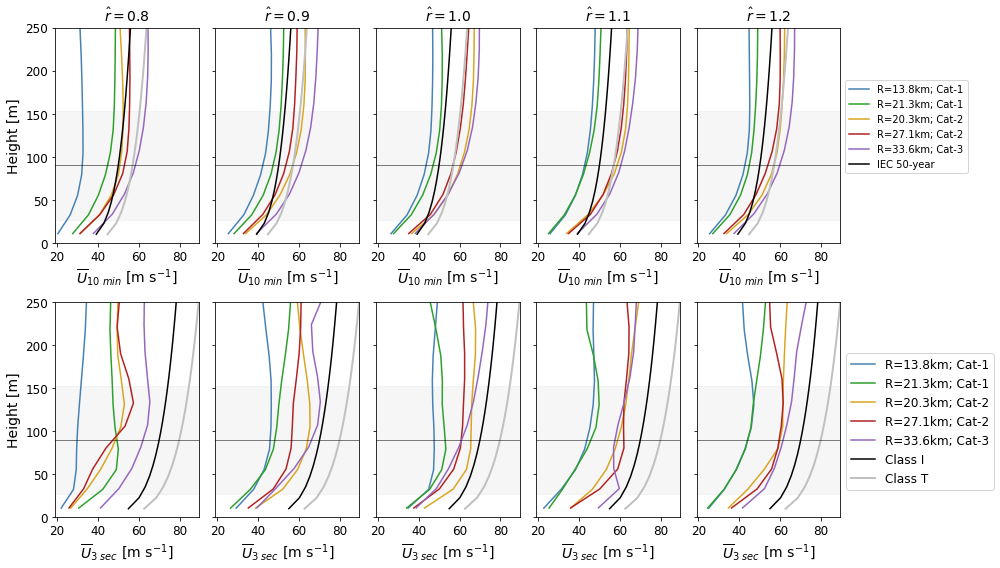

In [22]:
#%% Figure showing 10-min wind speed profile at different radial locations
minnn = 0
maxxx = 100
z_hh = 90
D = 126

mpyplot.figure(figsize=(14,8))
## 10-min
for i in np.arange(len(r_r)):
    mpyplot.subplot(2,len(r_r),i+1)
    mpyplot.title(r'$\hat{r} = $'+str(r_r[i]),fontsize=14)
    # Hurricane data
    if i==len(r_r)-1:
        mpyplot.plot(U10_z_26[:,i_r_26[i]],z_26,color=col_26,label='R='+str(np.round(r_eye_26/1000,1))+'km; Cat-1')
        mpyplot.plot(U10_z_28[:,i_r_28[i]],z_28,color=col_28,label='R='+str(np.round(r_eye_28/1000,1))+'km; Cat-1')
        mpyplot.plot(U10_z_30[:,i_r_30[i]],z_30,color=col_30,label='R='+str(np.round(r_eye_30/1000,1))+'km; Cat-2')
        mpyplot.plot(U10_z_32[:,i_r_32[i]],z_32,color=col_32,label='R='+str(np.round(r_eye_32/1000,1))+'km; Cat-2')
        mpyplot.plot(U10_z_34[:,i_r_34[i]],z_34,color=col_34,label='R='+str(np.round(r_eye_34/1000,1))+'km; Cat-3')
        mpyplot.plot(U_50_classI,z_TL,'-k',label='IEC 50-year')
#         mpyplot.plot(U_1_classI,z_TL,':k',label='IEC 1-year',linewidth=1.5) 
        mpyplot.plot(U_50_classT,z_TL,'-',color='silver',linewidth=2)
#         mpyplot.plot(U_1_classT,z_TL,':',linewidth=1.8,color='silver')
        mpyplot.legend(loc=3,ncol=1,bbox_to_anchor=[1, 0.3])
    else:
        mpyplot.plot(U10_z_26[:,i_r_26[i]],z_26,color=col_26)
        mpyplot.plot(U10_z_28[:,i_r_28[i]],z_28,color=col_28)
        mpyplot.plot(U10_z_30[:,i_r_30[i]],z_30,color=col_30)
        mpyplot.plot(U10_z_32[:,i_r_32[i]],z_32,color=col_32)
        mpyplot.plot(U10_z_34[:,i_r_34[i]],z_34,color=col_34)
        mpyplot.plot(U_50_classI,z_TL,'-k')
#         mpyplot.plot(U_1_classI,z_TL,':k',linewidth=1.5) 
        mpyplot.plot(U_50_classT,z_TL,'-',color='silver',linewidth=2)
#         mpyplot.plot(U_1_classT,z_TL,':',linewidth=1.8,color='silver')
    # Turbine rotor layer
    mpyplot.fill([minnn,maxxx,maxxx,minnn],[z_hh-0.5*D,z_hh-0.5*D,z_hh+0.5*D,z_hh+0.5*D],alpha=0.2,color='lightgrey')
    mpyplot.plot([minnn,maxxx],[z_hh,z_hh],'-k',linewidth=0.5)
    # Limits
    mpyplot.ylim(0,250)
    mpyplot.xlim(0.90*np.min(U10_z_26),1.05*np.max(U10_z_34))
    mpyplot.xlim(1.15*np.min(U3_z_26),1.12*np.max(U3_z_34))
    # Labels
    if i==0:
        mpyplot.ylabel('Height [m]',fontsize=14)
        locs,labs=mpyplot.yticks(fontsize=12)
    else:
        mpyplot.yticks(locs,'')
    mpyplot.xticks(fontsize=12)
    mpyplot.xlabel(r'$\overline{U}_{10\ min}$ [m s$^{-1}$]',fontsize=14)

    
## 3-sec
for i in np.arange(len(r_r)):
    mpyplot.subplot(2,len(r_r),len(r_r) + i+1)
#     mpyplot.title(r'$\hat{r} = $'+str(r_r[i]),fontsize=14)
    # Hurricane data
    if i==len(r_r)-1:
        mpyplot.plot(U3_z_26[:,i_r_26[i]],z_26,color=col_26,label='R='+str(np.round(r_eye_26/1000,1))+'km; Cat-1')
        mpyplot.plot(U3_z_28[:,i_r_28[i]],z_28,color=col_28,label='R='+str(np.round(r_eye_28/1000,1))+'km; Cat-1')
        mpyplot.plot(U3_z_30[:,i_r_30[i]],z_30,color=col_30,label='R='+str(np.round(r_eye_30/1000,1))+'km; Cat-2')
        mpyplot.plot(U3_z_32[:,i_r_32[i]],z_32,color=col_32,label='R='+str(np.round(r_eye_32/1000,1))+'km; Cat-2')
        mpyplot.plot(U3_z_34[:,i_r_34[i]],z_34,color=col_34,label='R='+str(np.round(r_eye_34/1000,1))+'km; Cat-3')
        mpyplot.plot(U_e50_classI,z_TL,'-k',label='Class I')
#         mpyplot.plot(U_e1_classI,z_TL,':k',linewidth=1.5) 
        mpyplot.plot(U_e50_classT,z_TL,'-',color='silver',label='Class T',linewidth=2)
#         mpyplot.plot(U_e1_classT,z_TL,':',linewidth=1.8,color='silver')
#         mpyplot.plot([-1,-1],[-1,-1],'-',color='silver',label='50-year')#,linewidth=1.5) 
#         mpyplot.plot([-1,-1],[-1,-1],':',color='silver',label='1-year',linewidth=1.5) 
        mpyplot.legend(loc=3,ncol=1,bbox_to_anchor=[1, 0.1],fontsize=12)
    else:
        mpyplot.plot(U3_z_26[:,i_r_26[i]],z_26,color=col_26)
        mpyplot.plot(U3_z_28[:,i_r_28[i]],z_28,color=col_28)
        mpyplot.plot(U3_z_30[:,i_r_30[i]],z_30,color=col_30)
        mpyplot.plot(U3_z_32[:,i_r_32[i]],z_32,color=col_32)
        mpyplot.plot(U3_z_34[:,i_r_34[i]],z_34,color=col_34)
        mpyplot.plot(U_e50_classI,z_TL,'-k')
#         mpyplot.plot(U_e1_classI,z_TL,':k',linewidth=1.5) 
        mpyplot.plot(U_e50_classT,z_TL,'-',color='silver',linewidth=2)
#         mpyplot.plot(U_e1_classT,z_TL,':',linewidth=1.8,color='silver')
        # ,linewidth=1.5,color='lightgrey')
    # Turbine rotor layer
    mpyplot.fill([minnn,maxxx,maxxx,minnn],[z_hh-0.5*D,z_hh-0.5*D,z_hh+0.5*D,z_hh+0.5*D],alpha=0.2,color='lightgrey')
    mpyplot.plot([minnn,maxxx],[z_hh,z_hh],'-k',linewidth=0.5)
    # Limits
    mpyplot.ylim(0,250)
    mpyplot.xlim(0.90*np.min(U3_z_26),1.05*np.max(U3_z_34))
    mpyplot.xlim(1.15*np.min(U3_z_26),1.12*np.max(U3_z_34))
    # Labels
    if i==0:
        mpyplot.ylabel('Height [m]',fontsize=14)
        locs,labs=mpyplot.yticks(fontsize=12)
    else:
        mpyplot.yticks(locs,'')
    mpyplot.xticks(fontsize=12)
    mpyplot.xlabel(r'$\overline{U}_{3\ sec}$ [m s$^{-1}$]',fontsize=14)
    
mpyplot.tight_layout()
mpyplot.savefig(dirFig + "profiles_10_3.png",facecolor='w',edgecolor='w',dpi=400,bbox_inches='tight')


In [14]:
1.2*np.min(U3_z_26)

19.938826066692265